# MGH IHP Publication statistics
In this notebook, we will use the data retrieved from OpenAlex to analyze the trends in publications of MGHIHP

To find an institution ID, please type in your browser https://api.openalex.org/institutions?search=mgh%20Institute%20of%20health%20professions (replace the last bit with your desired institution name). Please find one that looks correct in the results and copy/paste its "id" field below.

Similarly, to find a specific author, please enter in your browser this url https://api.openalex.org/authors?search=jordan%20green (replace the name at the end by whatever you need) and copy/paste the id.

In [34]:
home_institution = "https://openalex.org/I158133745"
begin = 2010
end = 2023

top_n_topics = 20
top_n_rankings = 20

### Data loading

In [49]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pprint
import itertools
import networkx as nx
import csv

In [5]:
pip install pyalex

Note: you may need to restart the kernel to use updated packages.


In [6]:
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

In [7]:
sample = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").get()
pprint.pprint(sample)

[{'abstract_inverted_index': None,
  'apc_list': None,
  'apc_paid': None,
  'authorships': [{'author': {'display_name': 'Katrin Tomanek',
                              'id': 'https://openalex.org/A5002347902',
                              'orcid': 'https://orcid.org/0000-0002-9873-7144'},
                   'author_position': 'first',
                   'countries': ['US'],
                   'institutions': [{'country_code': 'US',
                                     'display_name': 'Google (United States)',
                                     'id': 'https://openalex.org/I1291425158',
                                     'lineage': ['https://openalex.org/I1291425158',
                                                 'https://openalex.org/I4210128969'],
                                     'ror': 'https://ror.org/00njsd438',
                                     'type': 'company'}],
                   'is_corresponding': False,
                   'raw_affiliation_string': 'Google Res

                  {'author': {'display_name': 'Elizabeth Bonawitz',
                              'id': 'https://openalex.org/A5053594805',
                              'orcid': None},
                   'author_position': 'middle',
                   'countries': [],
                   'institutions': [],
                   'is_corresponding': False,
                   'raw_affiliation_string': 'Harvard Graduate School of '
                                             'Education',
                   'raw_affiliation_strings': ['Harvard Graduate School of '
                                               'Education'],
                   'raw_author_name': 'Elizabeth Bonawitz'},
                  {'author': {'display_name': 'Joanna A. Christodoulou',
                              'id': 'https://openalex.org/A5055261161',
                              'orcid': 'https://orcid.org/0000-0001-8167-8021'},
                   'author_position': 'middle',
                   'countries': ['US'],

In [8]:
pager = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").paginate(per_page=200)
pages = []
for page in pager:
    print(len(page), "additional entries collected...")
    pages = pages + page
print(len(pages), "total entries")
data = pages

200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
39 additional entries collected...
0 additional entries collected...
3039 total entries


Saving a local copy of the database

In [9]:
# The filename where you want to save the JSON data
filename = 'IHP2024.json'

# Saving the list of dictionaries as a JSON file
with open(filename, 'w') as file:
    json.dump(pages, file, indent=4)

print(f'Data saved to {filename}')

Data saved to IHP2024.json


save a .csv version with just some core information

In [48]:
# Specify the CSV file where you want to save the information
csv_file_path = 'output_data.csv'  # Update this to your desired CSV file path

# Define the CSV headers
headers = ['ID', 'Title', 'Publication Year', 'Authors', 'Cited By Count', 'Author Affiliations']

# Write data to the CSV file
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    for publication in data:
        # Extract relevant information from each publication
        pub_id = publication.get('id')
        title = publication.get('title')
        pub_year = publication.get('publication_year')
        cited_by_count = publication.get('cited_by_count', 0)
        
        # Concatenate author names
        authors = ', '.join([authorship.get('author', {}).get('display_name', 'N/A') for authorship in publication.get('authorships', [])])

        # Concatenate all affiliations for all authors
        affiliations = '; '.join([', '.join([inst.get('display_name', 'N/A') for inst in authorship.get('institutions', [])]) for authorship in publication.get('authorships', [])])

        # Write the publication data to the CSV
        writer.writerow({
            'ID': pub_id,
            'Title': title,
            'Publication Year': pub_year,
            'Authors': authors,
            'Cited By Count': cited_by_count,
            'Author Affiliations': affiliations
        })

print(f"Data successfully written to {csv_file_path}")


Data successfully written to output_data.csv


plotting code

In [10]:
def plot_publications_with_dynamic_sizing(publications_data, begin, end, title="Publications"):
    # Filter publications within the specified time window
    filtered_publications = {year: count for year, count in publications_data.items() if begin <= year <= end}
    
    # Sort the dictionary by year
    years = sorted(filtered_publications.keys())
    counts = [filtered_publications[year] for year in years]
    
    # Calculate year-to-year percentage increase
    percentage_increases = [0]  # No increase for the first year
    for i in range(1, len(years)):
        if counts[i-1] == 0:  # Avoid division by zero
            increase = 0
        else:
            increase = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
        percentage_increases.append(increase)
    
    # Determine the size of the plot based on the number of years to display
    width_per_year = 1  # Assumed width per year for readability
    fig_width = max(len(years) * width_per_year, 8)  # Ensure a minimum width for very short ranges
    fig_height = 6  # Fixed height

    fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

    # Plot histogram of publications per year
    bars = ax1.bar(years, counts, color='b', alpha=0.6, label='Publications per Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Publications', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Annotate the bars with the percentage increases
    for bar, increase in zip(bars, percentage_increases):
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{increase:+.1f}%', ha='center', va='bottom')

    # Title and legend
    plt.title(title + ' per Year and Year-to-Year Increase in Percentage')
    fig.tight_layout()
    #fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

    plt.show()

## First of all, let us compute the volume of publication per year and the percentage increase in publication volume per year

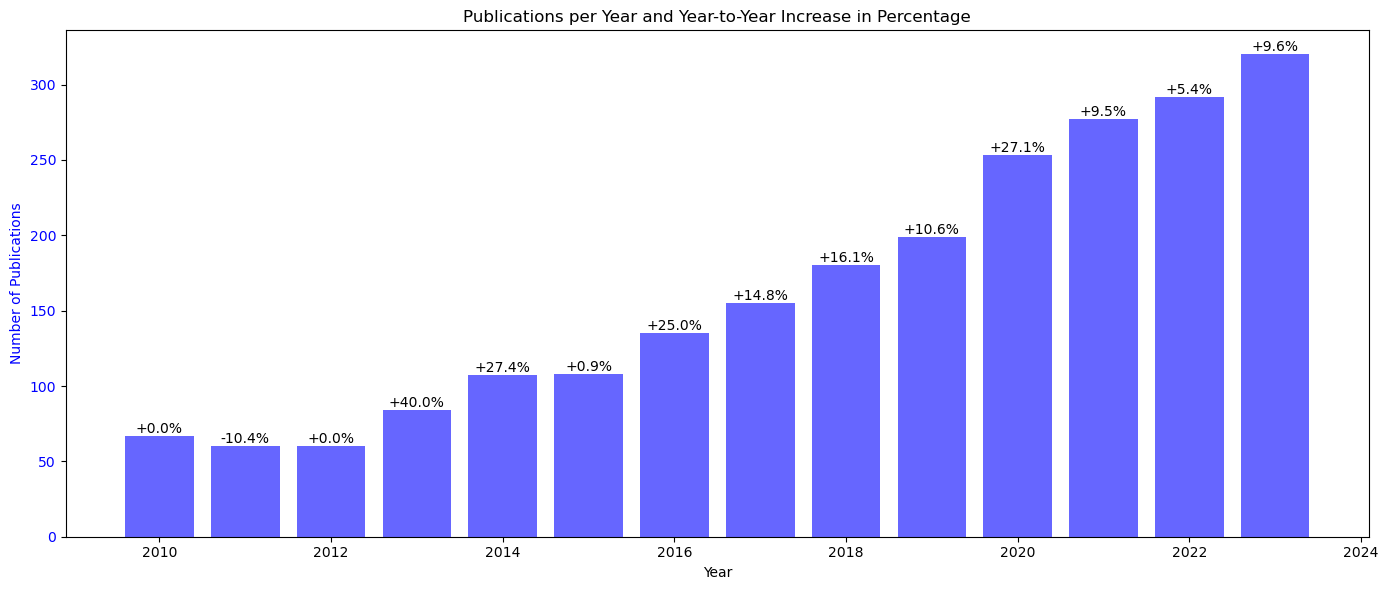

In [11]:
# Count the number of publications per year
publications_per_year = {}
for item in data:
    year = item.get('publication_year')
    if year in publications_per_year:
        publications_per_year[year] += 1
    else:
        publications_per_year[year] = 1

plot_publications_with_dynamic_sizing(publications_per_year, begin, end)

## We now compute the number of collaborations with authors from a different institution per year 

As the sum of authors affiliated with another institution appearing on our publications

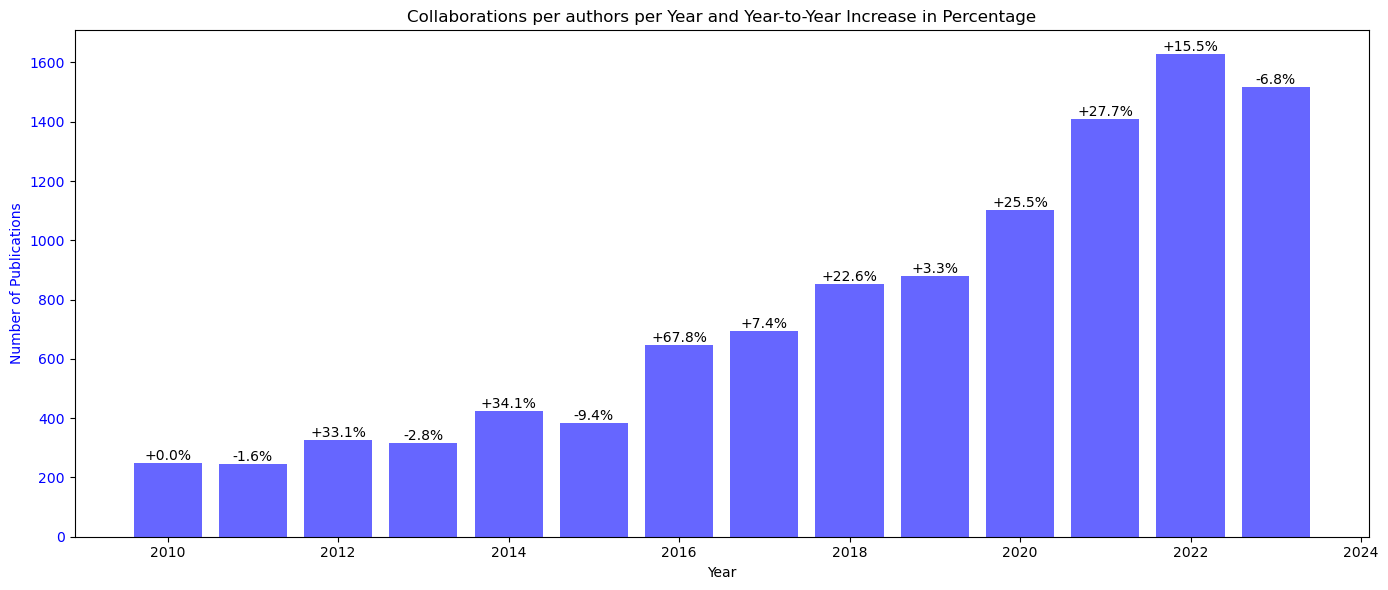

In [12]:
def count_authors_excluding_institution_all_years(data, excluded_institution_id):
    author_counts_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        count = 0
        for authorship in publication.get('authorships', []):
            # Check if author is affiliated with the excluded institution
            affiliated_with_excluded = any(
                excluded_institution_id in institution['id'] for institution in authorship.get('institutions', []))
            if not affiliated_with_excluded:
                count += 1
        
        if year in author_counts_by_year:
            author_counts_by_year[year] += count
        else:
            author_counts_by_year[year] = count

    return author_counts_by_year

# Count authors not affiliated with the specified institution for all publications in the dataset
author_counts_excluding_institution = count_authors_excluding_institution_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(author_counts_excluding_institution, begin, end, "Collaborations per authors")


## Number of different instiutions collaborated with per year

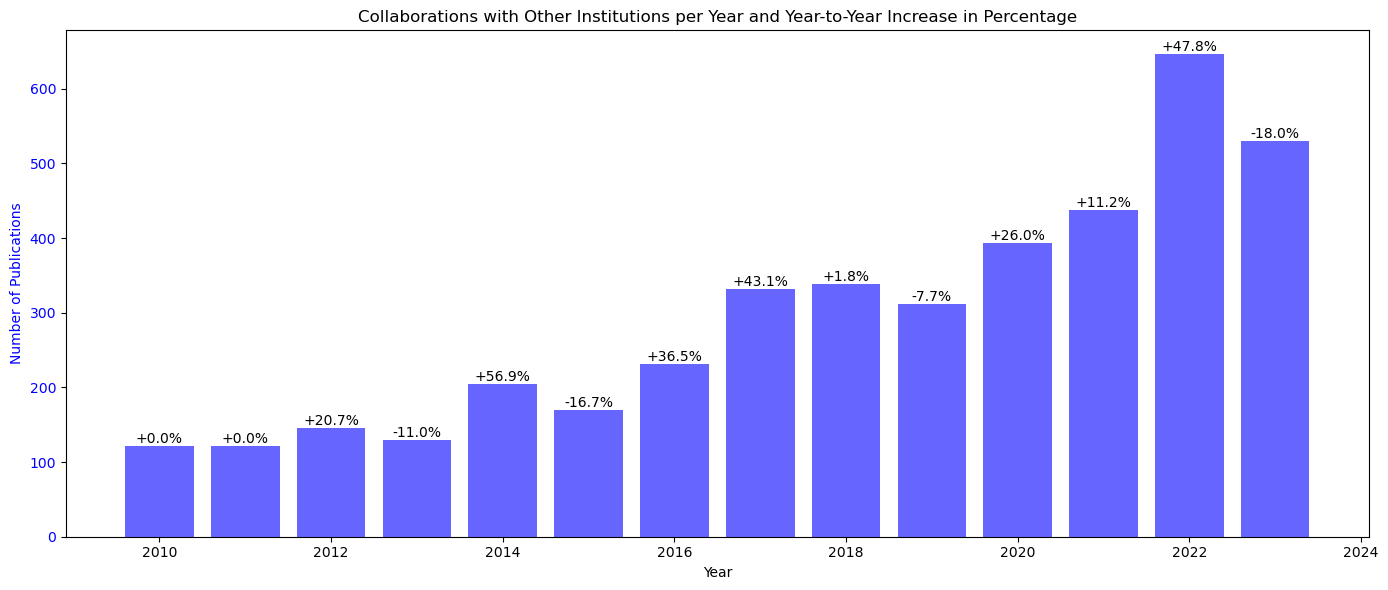

In [13]:
def count_unique_collaborating_institutions_all_years(data, excluded_institution_id):
    unique_institutions_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_institutions = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                if institution['id'] != excluded_institution_id:
                    unique_institutions.add(institution['id'])

        if year in unique_institutions_by_year:
            unique_institutions_by_year[year].update(unique_institutions)
        else:
            unique_institutions_by_year[year] = unique_institutions

    # Convert sets to counts
    collaborating_institution_counts = {year: len(institutions) for year, institutions in unique_institutions_by_year.items()}

    return collaborating_institution_counts

# Count unique collaborating institutions per year, excluding a specific institution
collaborating_institutions_counts = count_unique_collaborating_institutions_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_institutions_counts, begin, end, "Collaborations with Other Institutions")


## Number of different foreign countries collaborated with per year

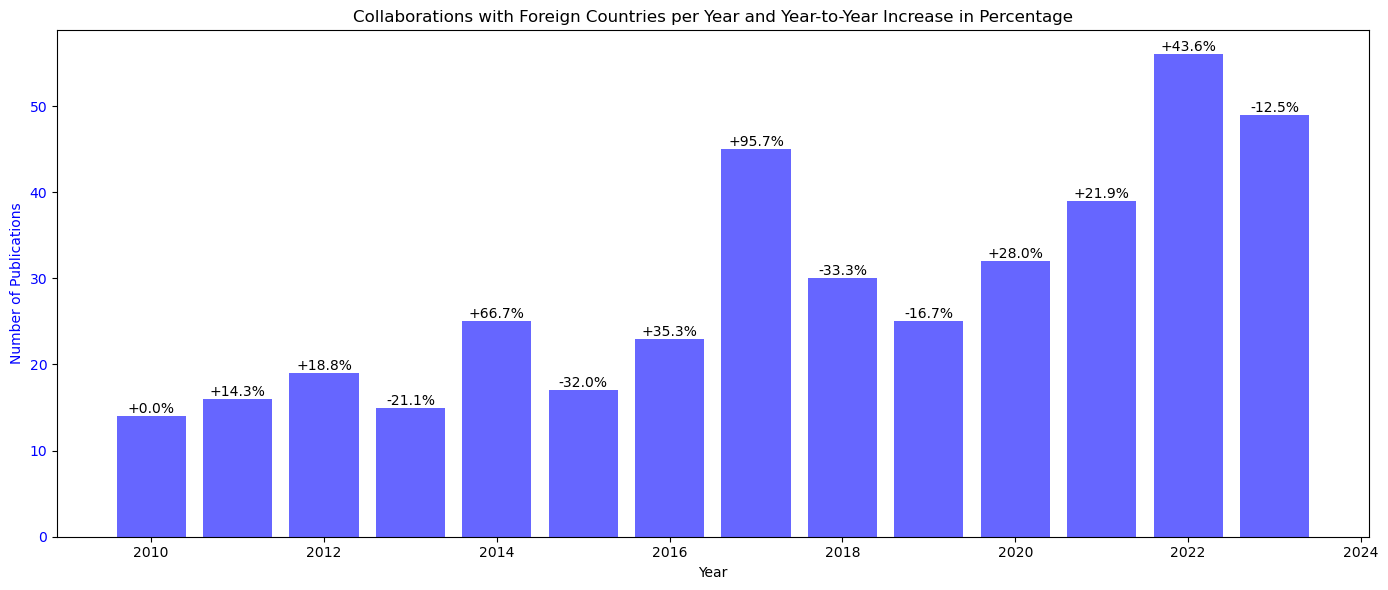

In [14]:
def count_unique_collaborating_countries_all_years(data, excluded_institution_id):
    unique_countries_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_countries = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                # Only consider institutions other than the excluded one
                if institution['id'] != excluded_institution_id:
                    # Add the country of the institution, if available
                    country_code = institution.get('country_code')
                    if country_code:
                        unique_countries.add(country_code)

        if year in unique_countries_by_year:
            unique_countries_by_year[year].update(unique_countries)
        else:
            unique_countries_by_year[year] = unique_countries

    # Convert sets to counts
    collaborating_country_counts = {year: len(countries) for year, countries in unique_countries_by_year.items()}

    return collaborating_country_counts

# Count unique collaborating countries per year, excluding a specific institution
collaborating_countries_counts = count_unique_collaborating_countries_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_countries_counts, begin, end, "Collaborations with Foreign Countries")


## Number of different publication venues, journals, etc per year

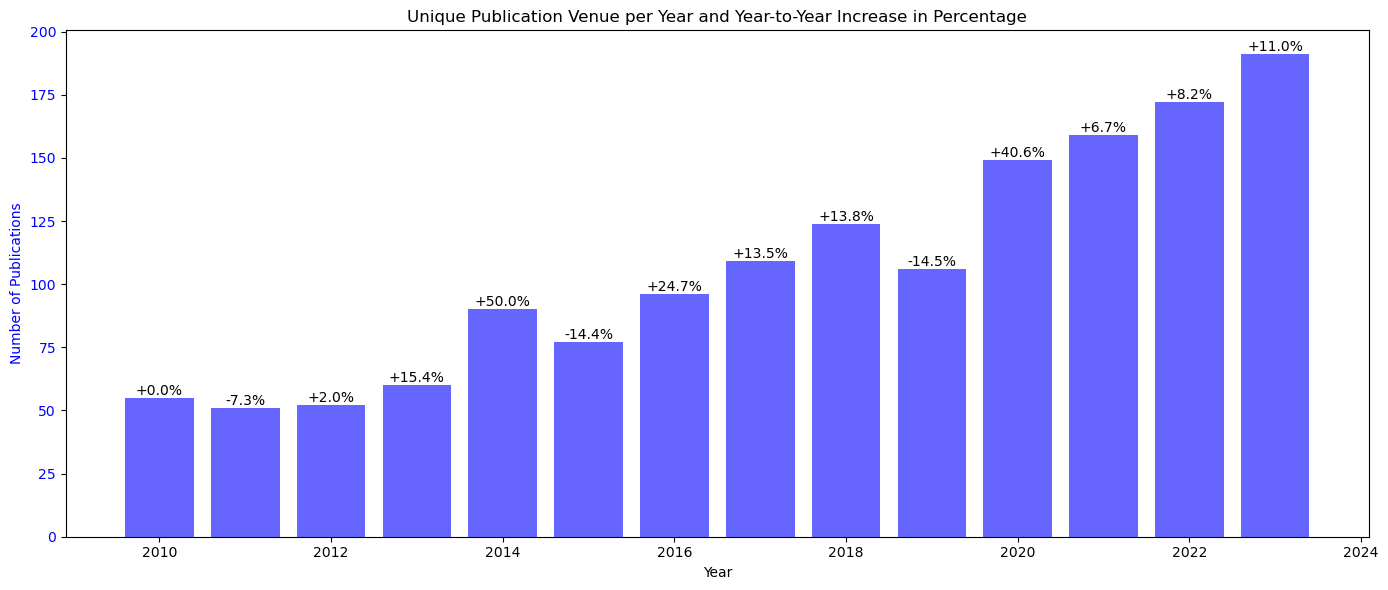

In [15]:
def count_unique_venues_all_years_corrected(data):
    unique_venues_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        # Ensure 'primary_location' is a dictionary and 'source' is not None before accessing 'id'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        venue_id = source.get('id') if source else None

        if venue_id:  # Only consider publications with a known venue
            if year in unique_venues_by_year:
                unique_venues_by_year[year].add(venue_id)
            else:
                unique_venues_by_year[year] = {venue_id}

    # Convert sets to counts
    unique_venue_counts = {year: len(venues) for year, venues in unique_venues_by_year.items()}

    return unique_venue_counts


# Count unique venues per year with the fixed function
unique_venues_counts_fixed = count_unique_venues_all_years_corrected(data)

# Plotting the result with the fixed data
plot_publications_with_dynamic_sizing(unique_venues_counts_fixed, begin, end, "Unique Publication Venue")


## Number of first authorships per year

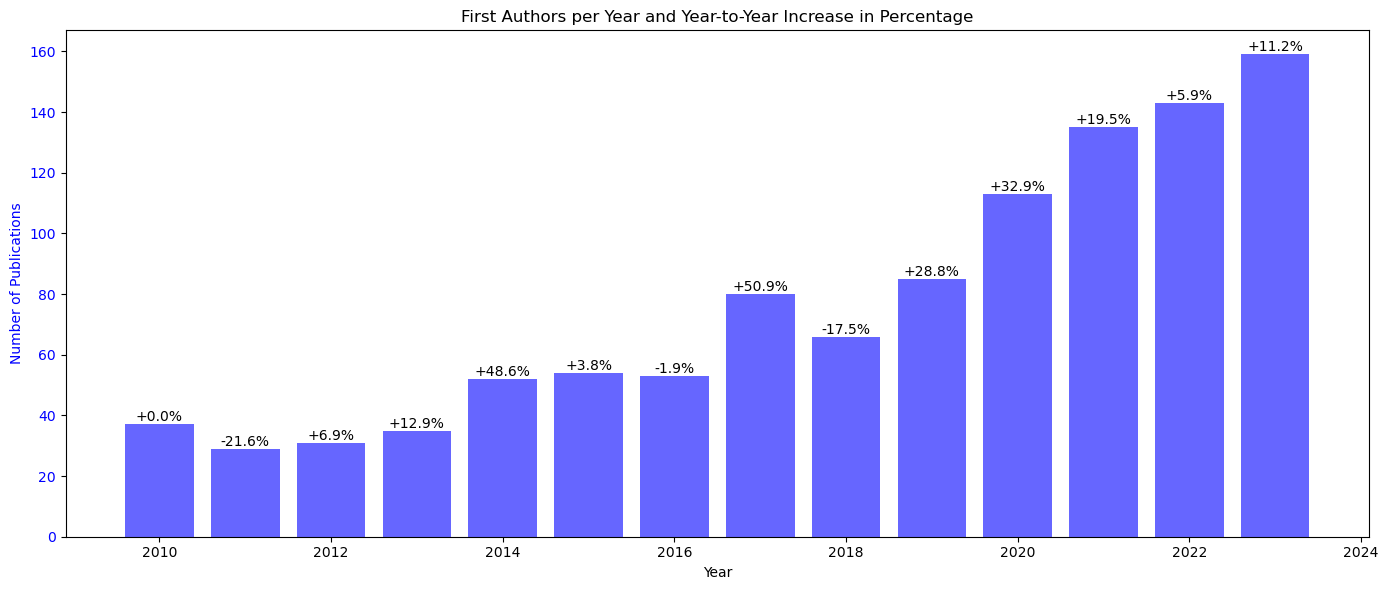

In [16]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'first':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = any(
                    home_institution_id == institution['id'] for institution in authorship.get('institutions', []))
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1
                break  # Only consider the first author, so break after checking

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
first_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(first_author_affiliation_counts, begin, end, "First Authors")


## Number of last authorships per year

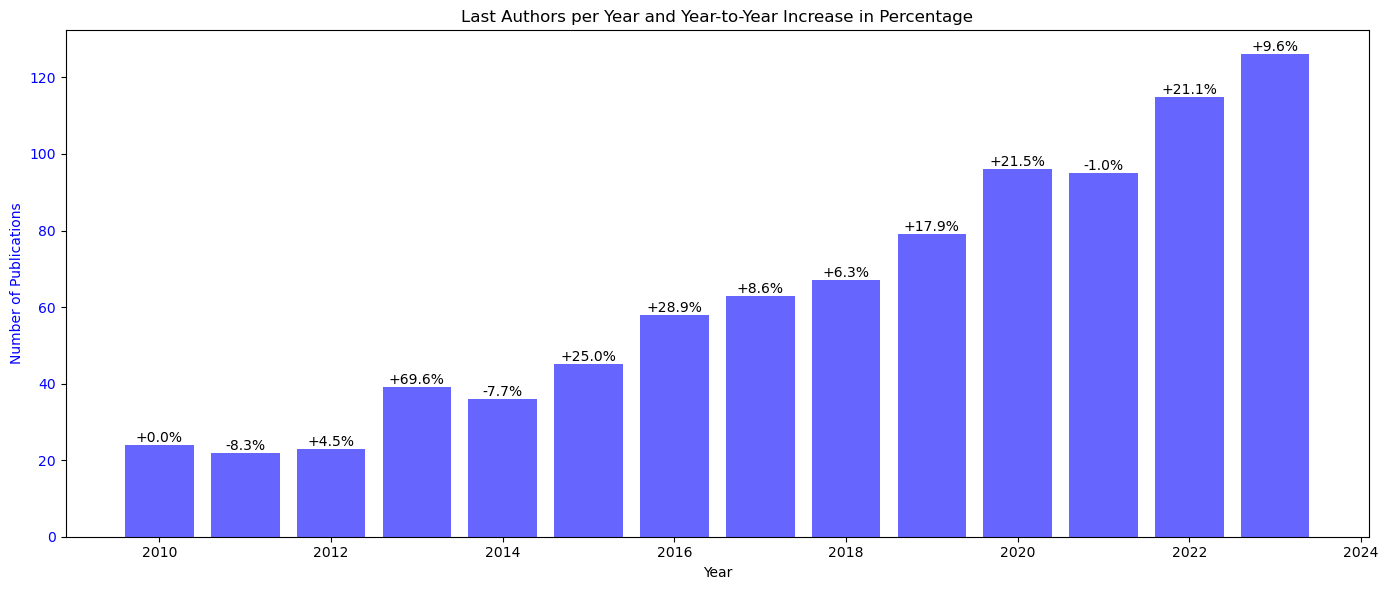

In [17]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'last':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = home_institution_id in [institution['id'] for institution in authorship.get('institutions', [])]
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
last_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(last_author_affiliation_counts, begin, end, "Last Authors")

## Number of citations attributed to the year's papers per year, to date

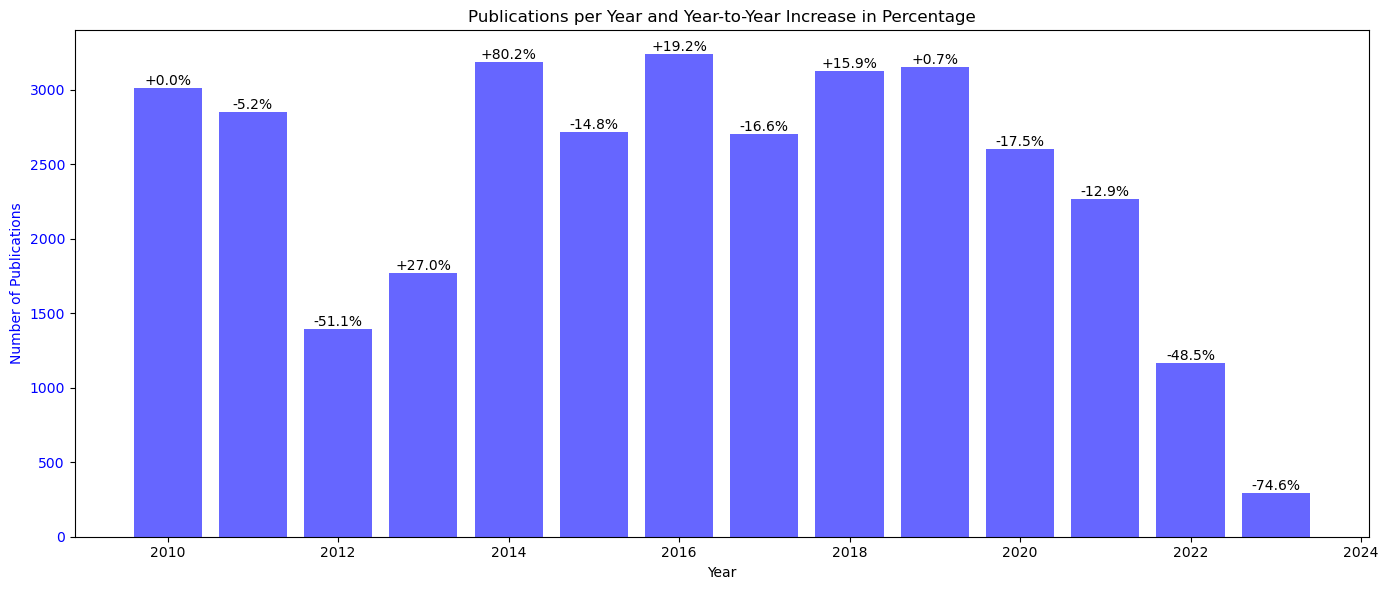

In [18]:
def count_citations_per_year(data):
    citations_per_year = {}

    for publication in data:
        year = publication.get('publication_year')
        citations_count = publication.get('cited_by_count', 0)

        if year in citations_per_year:
            citations_per_year[year] += citations_count
        else:
            citations_per_year[year] = citations_count

    return citations_per_year

# Count the total number of citations accumulated by publications in each year
citations_counts_per_year = count_citations_per_year(data)

# Plotting the result
plot_publications_with_dynamic_sizing(citations_counts_per_year, begin, end)


## Number of received citations per year

## Looking at the most popular topics over the selected time period and how oftne they co-occur in papers

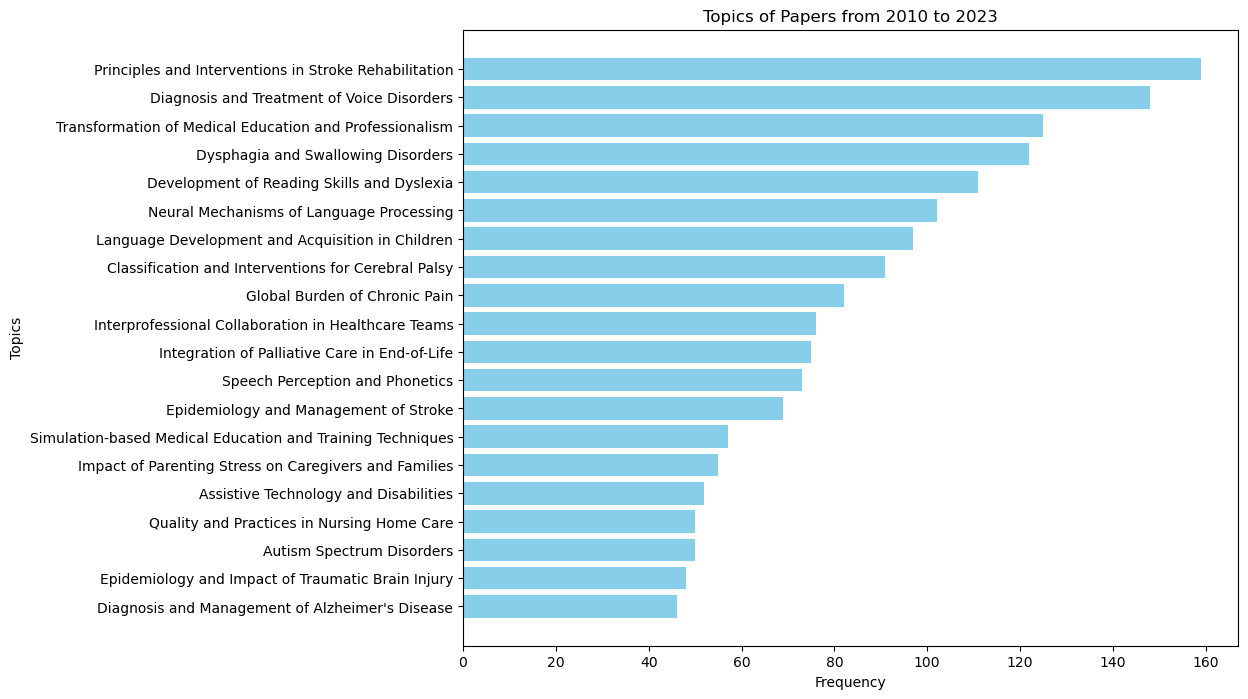

In [23]:
def plot_paper_topics(data, begin, end, top_n=10):
    topic_counts = {}

    # Iterate through each publication
    for publication in data:
        year = publication.get('publication_year')
        # Check if the publication is within the specified time span
        if begin <= year <= end:
            # Iterate through the topics of each publication
            for topic in publication.get('topics', []):
                topic_name = topic.get('display_name')
                # Increment the count for each topic
                if topic_name in topic_counts:
                    topic_counts[topic_name] += 1
                else:
                    topic_counts[topic_name] = 1

    # Prepare data for plotting
    topics = list(topic_counts.keys())
    counts = list(topic_counts.values())

    # Sort the topics by count
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_topics = [topics[i] for i in sorted_indices][:top_n]
    sorted_counts = [counts[i] for i in sorted_indices][:top_n]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_topics, sorted_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Topics')
    plt.title(f'Topics of Papers from {begin} to {end}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

# Example usage
plot_paper_topics(data, begin, end, top_n=top_n_topics)


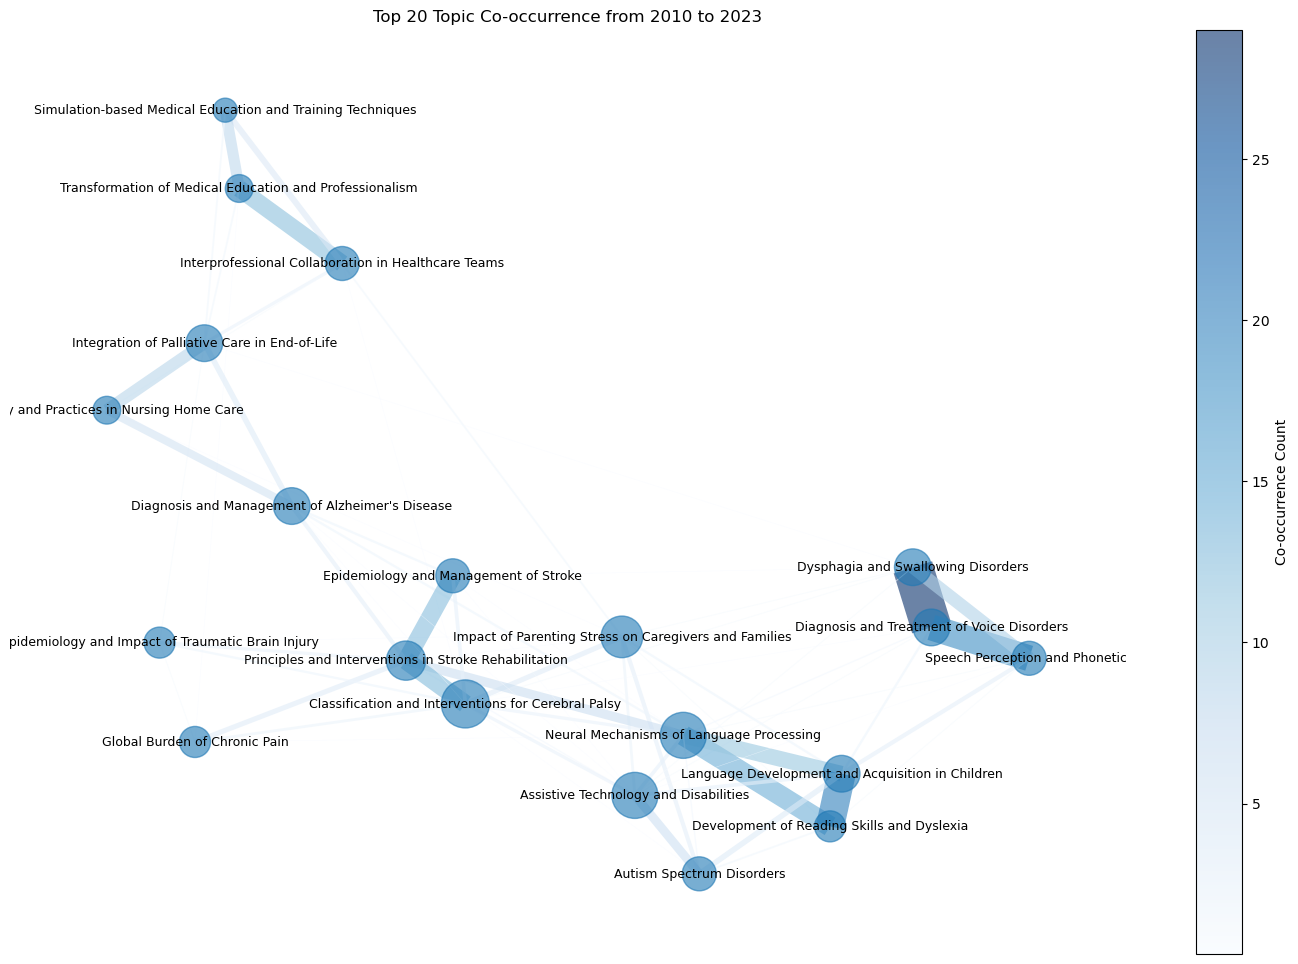

In [31]:
def get_top_topics(data, begin, end, top_n=10):
    topic_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            for topic in publication.get('topics', []):
                topic_name = topic.get('display_name')
                if topic_name in topic_counts:
                    topic_counts[topic_name] += 1
                else:
                    topic_counts[topic_name] = 1

    # Sort topics by frequency and select the top N
    sorted_topics = sorted(topic_counts, key=topic_counts.get, reverse=True)
    top_topics = sorted_topics[:top_n]

    return set(top_topics)

def build_cooccurrence_matrix(data, begin, end, top_topics):
    cooccurrence = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            topics = [topic.get('display_name') for topic in publication.get('topics', []) if topic.get('display_name') in top_topics]

            for topic1, topic2 in itertools.combinations(topics, 2):
                if topic1 > topic2:
                    topic1, topic2 = topic2, topic1
                
                if (topic1, topic2) not in cooccurrence:
                    cooccurrence[(topic1, topic2)] = 0
                cooccurrence[(topic1, topic2)] += 1

    return cooccurrence

def plot_top_topic_cooccurrence_with_scale(data, begin, end, top_n=10):
    top_topics = get_top_topics(data, begin, end, top_n)
    cooccurrence = build_cooccurrence_matrix(data, begin, end, top_topics)

    G = nx.Graph()
    for (topic1, topic2), weight in cooccurrence.items():
        G.add_edge(topic1, topic2, weight=weight)

    node_sizes = [G.degree(topic) * 100 for topic in G if topic in top_topics]
    
    # Edge widths based on weight
    edge_widths = [G[u][v]['weight']/3 for u, v in G.edges() if u in top_topics and v in top_topics]

    # Position nodes using the spring layout
    pos = nx.spring_layout(G)

    plt.figure(figsize=(18, 12))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.6)

    # Draw edges with a colormap
    edges = nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_widths,
                                    edge_cmap=plt.cm.Blues, alpha=0.6)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Include a colorbar to interpret edge widths
    plt.colorbar(edges, label='Co-occurrence Count')

    plt.title(f'Top {top_n} Topic Co-occurrence from {begin} to {end}')
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example usage with your dataset, a specified time span, and focusing on the top 10 topics
plot_top_topic_cooccurrence_with_scale(data, begin, end, top_n=top_n_topics)


## Ranking of highest-ranking collaboarating institutions over the time span

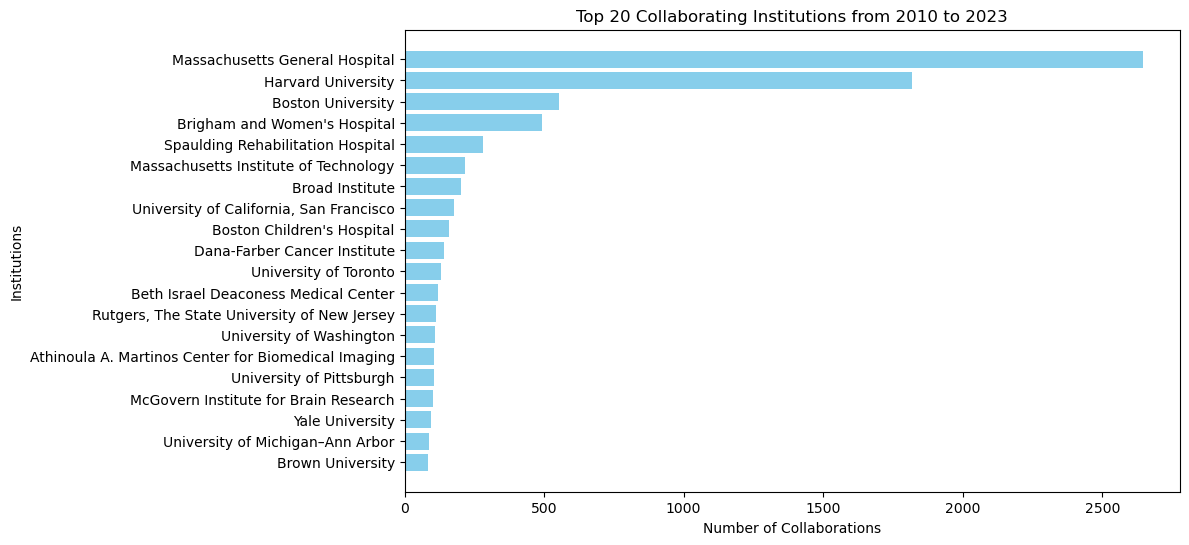

In [37]:
def plot_top_collaborating_institutions(data, begin, end, home_institution_id, top_n):
    collaboration_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            for authorship in publication.get('authorships', []):
                for institution in authorship.get('institutions', []):
                    inst_id = institution['id']
                    inst_name = institution.get('display_name', inst_id)  # Use institution ID if name is not available
                    if inst_id != home_institution_id:  # Exclude the home institution
                        if inst_name in collaboration_counts:
                            collaboration_counts[inst_name] += 1
                        else:
                            collaboration_counts[inst_name] = 1

    # Sort institutions by collaboration count and select the top N
    top_institutions = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_institution_names = [inst[0] for inst in top_institutions]
    collaboration_counts = [inst[1] for inst in top_institutions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_institution_names, collaboration_counts, color='skyblue')
    plt.xlabel('Number of Collaborations')
    plt.ylabel('Institutions')
    plt.title(f'Top {top_n} Collaborating Institutions from {begin} to {end}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

# Example usage of the function
plot_top_collaborating_institutions(data, begin, end, home_institution, top_n=top_n_rankings)

## Ranking of highest-ranking collaboarating countries over the time span

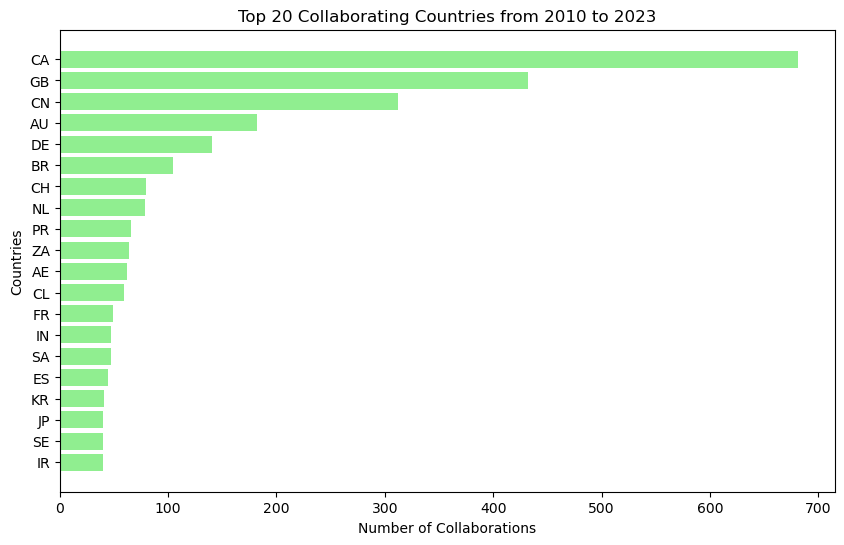

In [40]:
def plot_top_collaborating_countries(data, begin, end, home_country_code, top_n):
    collaboration_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            for authorship in publication.get('authorships', []):
                for institution in authorship.get('institutions', []):
                    country_code = institution.get('country_code')
                    if country_code and country_code != home_country_code:  # Exclude the home country
                        if country_code in collaboration_counts:
                            collaboration_counts[country_code] += 1
                        else:
                            collaboration_counts[country_code] = 1

    # Sort countries by collaboration count and select the top N
    top_countries = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_country_codes = [country[0] for country in top_countries]
    collaboration_counts = [country[1] for country in top_countries]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_country_codes, collaboration_counts, color='lightgreen')
    plt.xlabel('Number of Collaborations')
    plt.ylabel('Countries')
    plt.title(f'Top {top_n} Collaborating Countries from {begin} to {end}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

# Example usage of the function
home_country_code = 'US'  # Example country code, replace with actual home country code
plot_top_collaborating_countries(data, begin, end, home_country_code, top_n=top_n_rankings)


## Ranking of highest-ranking journals, venues, etc where the Home institution published

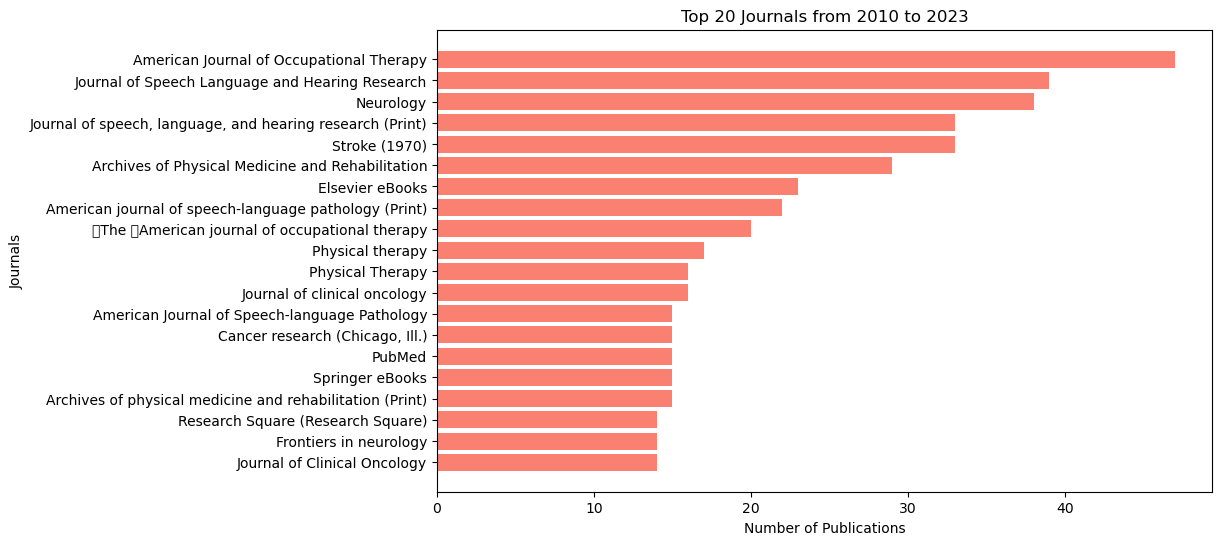

In [47]:
def plot_top_journals(data, begin, end, top_n):
    journal_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            # Ensure 'primary_location' is a dictionary before accessing 'source'
            primary_location = publication.get('primary_location', {})
            source = primary_location.get('source') if isinstance(primary_location, dict) else None
            journal_name = source.get('display_name') if source else None

            if journal_name:
                if journal_name in journal_counts:
                    journal_counts[journal_name] += 1
                else:
                    journal_counts[journal_name] = 1

    # Sort journals by publication count and select the top N
    top_journals = sorted(journal_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    journal_names = [journal[0] for journal in top_journals]
    publication_counts = [journal[1] for journal in top_journals]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(journal_names, publication_counts, color='salmon')
    plt.xlabel('Number of Publications')
    plt.ylabel('Journals')
    plt.title(f'Top {top_n} Journals from {begin} to {end}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()


# Example usage of the function
plot_top_journals(data, begin, end, top_n=top_n_rankings)